<a href="https://colab.research.google.com/github/bsh0137/GAN/blob/main/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100

In [3]:
def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(28 * 28 * 1, activation='tanh'))
  model.add(Reshape(img_shape))
  return model

In [4]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [5]:
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_siize, sample_interval):

  (X_train, _), (_, _) = mnist.load_data() # MNIST 데이터셋 로드

  X_train = X_train / 127.5 - 1.0   # tanh 활성 함수 사용을 위해 출력 값을 [-1, 1] 범위로 조정함. tanh가 sigmoid보다 더 또렷한 이미지를 만듦.
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1)) # 진짜 이미지 레이블: 1

  fake = np.zeros((batch_size, 1)) # 가자 이미지 레이블: 모두 0
  
  for iteration in range(iterations):
    
    idx = np.random.randint(0, X_train.shape[0], batch_size)  #진짜 이미지에서 랜덤 배치 가져오기.
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성

    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    d_loss_real = discriminator.train_on_batch(imgs, real) #판별자 훈련
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      sample_images(generator) # 생성된 이미지 샘플 출력
    

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim)) # 랜덤한 잡음 샘플링

  gen_imgs = generator.predict(z)

  gen_imgs = 0.5 * gen_imgs + 0.5 # 이미지 픽셀 값을 [0, 1]로 스케일 조정

  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

  cnt = 0
  
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

In [9]:
iterations = 5000
batch_size = 128
sample_interval = 1000

1000 [D 손실: 0.107415, 정확도: 97.66%] [G 손실: 2.288588]
2000 [D 손실: 0.210742, 정확도: 92.97%] [G 손실: 2.989088]
3000 [D 손실: 0.194324, 정확도: 91.80%] [G 손실: 2.612272]
4000 [D 손실: 0.060363, 정확도: 97.27%] [G 손실: 5.749105]
5000 [D 손실: 0.156106, 정확도: 93.75%] [G 손실: 5.360938]


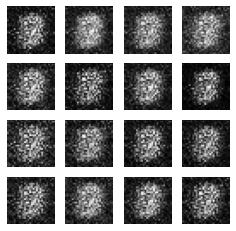

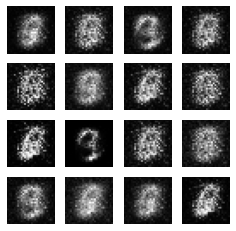

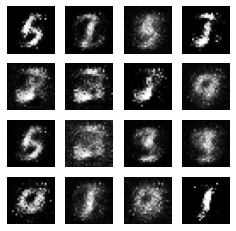

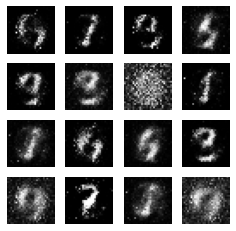

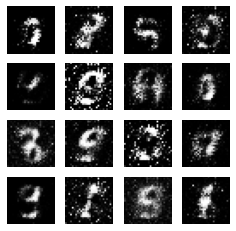

In [10]:
train(iterations, batch_size, sample_interval)